In [13]:
import os
import glob
import csv
import time

import math
import random
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from scipy.stats import norm
import ot
import matplotlib.pyplot as plt



ImportError: Failed to import any qt binding

In [95]:
pd.set_option('display.max_rows', 100)
df = pd.read_csv('../data/AAPL/output__AAPL_5min_year1month1.csv', delimiter=',')

In [96]:
df['datetime'] = pd.to_datetime(df['time'])
df['date'] = pd.to_datetime(df['time']).dt.date
df['time'] = pd.to_datetime(df['time']).dt.time
df['average'] = (df['high'] + df['low']) / 2

df = df.sort_values(by='datetime', ascending=True)
df = df.reset_index(drop=True)

In [92]:
def compute_rolling_average(df, days=30):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df[f'rolling_{days}d_average'] = df['average'].rolling(192*days, min_periods=max(192*(days-1), 1)).mean()
    return df


def compute_rolling_std(df, days=30):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df[f'rolling_{days}d_std'] = df['average'].rolling(192*days, min_periods=max(192*(days-1), 1)).std()
    return df


def compute_wasserstein_barycenter(df, days=30):
    df['date'] = pd.to_datetime(df['date'])    
    unique_dates = sorted(df['date'].unique())
    barycenters = {}
    
    for i in range(len(unique_dates) - days + 1):
        sub_df = df[df['date'].isin(unique_dates[i: i+days])]
        daily_distributions = []
        daily_sums = []
        daily_vols = []
        max_length = 0
        
        # Iterate each date in the span of days provided and get the sum & probability distribution
        # Data has inconsistent number of intervals in data, need to pad to ensure equal lengths
        for date in unique_dates[i: i+days]:
            day_data = sub_df[sub_df['date'] == date]['average'].values
            day_vol = sub_df[sub_df['date'] == date]['volume'].values
            daily_sums.append(np.sum(day_data))
            daily_vols.append(np.sum(day_vol))
            day_distribution = softmax(day_data)
            daily_distributions.append(np.pad(day_distribution, (0, 192 - len(day_distribution))))
        
        daily_sums = np.array(daily_sums)
        daily_distributions = np.array(daily_distributions)
        
        # Weight options: 1) uniform 2) normalized by price 3) normalized by volume traded
        weights = np.ones(days)/days
        normalized_sums = np.array(daily_sums) / np.sum(daily_sums)
        normalized_vol_sums = np.array(daily_vols) / np.sum(daily_vols)
        barycenter = ot.bregman.barycenter(daily_distributions.T, np.eye(192), reg=1e-3, weights=weights, method='sinkhorn_stabilized')
        barycenters[str(pd.to_datetime(unique_dates[i + days - 1]).date())] = barycenter
    return barycenters


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [40]:
df

time    open    high     low     close  volume            datetime  \
0     04:05:00  159.02  159.48  158.52  159.4800    8657 2023-03-23 04:05:00   
1     04:10:00  159.48  159.50  159.45  159.4900    4303 2023-03-23 04:10:00   
2     04:15:00  159.49  159.49  159.39  159.3900    6431 2023-03-23 04:15:00   
3     04:20:00  159.42  159.65  159.42  159.6400    7151 2023-03-23 04:20:00   
4     04:25:00  159.60  159.62  159.59  159.5900    2084 2023-03-23 04:25:00   
...        ...     ...     ...     ...       ...     ...                 ...   
3843  19:35:00  164.94  164.94  164.91  164.9200    2989 2023-04-21 19:35:00   
3844  19:40:00  164.90  164.90  164.90  164.9000     603 2023-04-21 19:40:00   
3845  19:50:00  164.92  164.94  164.92  164.9400    1592 2023-04-21 19:50:00   
3846  19:55:00  164.94  165.00  164.94  165.0000    1965 2023-04-21 19:55:00   
3847  20:00:00  164.97  164.97  164.92  164.9201    1494 2023-04-21 20:00:00   

            date  average  
0     2023-03-23  159.000  
1     2023-03-23  159.475  
2     2023-03-23  159.440  
3     2023-03-23  159.535  
4     2023-03-23  159.605  
...          ...      ...  
3843  2023-04-21  164.925  
3844  2023-04-21  164.900  
3845  2023-04-21  164.930  
3846  2023-04-21  164.970  
3847  2023-04-21  164.945  

[3848 rows x 9 columns]

In [97]:
df = compute_rolling_average(df, days=10)
df = compute_rolling_average(df, days=30)
df = compute_rolling_std(df, days=10)
df = compute_rolling_std(df, days=30)
barycenters_10d = compute_wasserstein_barycenter(df, days=10)

In [6]:
df

time    open    high     low     close  volume            datetime  \
0     04:05:00  159.02  159.48  158.52  159.4800    8657 2023-03-23 04:05:00   
1     04:10:00  159.48  159.50  159.45  159.4900    4303 2023-03-23 04:10:00   
2     04:15:00  159.49  159.49  159.39  159.3900    6431 2023-03-23 04:15:00   
3     04:20:00  159.42  159.65  159.42  159.6400    7151 2023-03-23 04:20:00   
4     04:25:00  159.60  159.62  159.59  159.5900    2084 2023-03-23 04:25:00   
...        ...     ...     ...     ...       ...     ...                 ...   
3843  19:35:00  164.94  164.94  164.91  164.9200    2989 2023-04-21 19:35:00   
3844  19:40:00  164.90  164.90  164.90  164.9000     603 2023-04-21 19:40:00   
3845  19:50:00  164.92  164.94  164.92  164.9400    1592 2023-04-21 19:50:00   
3846  19:55:00  164.94  165.00  164.94  165.0000    1965 2023-04-21 19:55:00   
3847  20:00:00  164.97  164.97  164.92  164.9201    1494 2023-04-21 20:00:00   

           date  average  rolling_10d_average  rolling_30d_average  \
0    2023-03-23  159.000                  NaN                  NaN   
1    2023-03-23  159.475                  NaN                  NaN   
2    2023-03-23  159.440                  NaN                  NaN   
3    2023-03-23  159.535                  NaN                  NaN   
4    2023-03-23  159.605                  NaN                  NaN   
...         ...      ...                  ...                  ...   
3843 2023-04-21  164.925           164.244781                  NaN   
3844 2023-04-21  164.900           164.245300                  NaN   
3845 2023-04-21  164.930           164.245790                  NaN   
3846 2023-04-21  164.970           164.246222                  NaN   
3847 2023-04-21  164.945           164.246587                  NaN   

      rolling_10d_std  rolling_30d_std  
0                 NaN              NaN  
1                 NaN              NaN  
2                 NaN              NaN  
3                 NaN              NaN  
4                 NaN              NaN  
...               ...              ...  
3843         2.192407              NaN  
3844         2.192445              NaN  
3845         2.192492              NaN  
3846         2.192553              NaN  
3847         2.192611              NaN  

[3848 rows x 13 columns]

In [109]:
def compute_geometric_volatility(df, barycenters, window_size=6, rolling_average=30, epsilon=1e-2):
    df[f'wp_distance_{rolling_average}d'] = None
    df[f'alpha_{rolling_average}d'] = None
    
    for date in df.loc[df[f'rolling_{rolling_average}d_average'].notnull()]['date'].unique():
        print('date: ', date)
        for i in range(window_size, len(df.loc[df['date'] == date])):
            window = df[i-window_size: i]
            end_time = window.iloc[-1]['time']
            
            curr_distr = softmax(window['average'].values)
            barycenter_distr = barycenters[np.datetime_as_string(date, unit='D')][i-window_size: i]
            renormalized_barycenter_distr = [x/sum(barycenter_distr) for x in barycenter_distr]
            wp_dist = wasserstein_distance(curr_distr, renormalized_barycenter_distr)
            df.loc[(df['time'] == end_time) & (df['date']==date), f'wp_distance_{rolling_average}d'] = wp_dist
            df.loc[(df['time'] == end_time) & (df['date']==date), f'alpha_{rolling_average}d'] = 1 if wp_dist > epsilon else 0
            

            print('i: ', i)
            print('date time: ', np.datetime_as_string(date, unit='D'), end_time)
            print('len of df for date: ', len(df.loc[df['date']==date]))
            print('wp_dist: ', wp_dist)
            print('window\n', window, '\n')
            '''
            print('curr values: ', window['average'].values)
            print('curr_distr: ', curr_distr)
            print('barycenter_distr: ', barycenter_distr)
            print('renorm_barycenter_distr: ', renormalized_barycenter_distr)
            print('matching row: ', df.loc[(df['time'] == end_time) & (df['date']==date)])
            '''
    return df

In [70]:
for k, v in barycenters_10d.items():
    print(k, len(v))

2023-04-05 192
2023-04-06 192
2023-04-10 192
2023-04-11 192
2023-04-12 192
2023-04-13 192
2023-04-14 192
2023-04-17 192
2023-04-18 192
2023-04-19 192
2023-04-20 192
2023-04-21 192


In [126]:
epsilon = 0.05
df = compute_geometric_volatility(df, barycenters_10d, window_size=8, rolling_average=10, epsilon=epsilon)

date:  2023-04-05T00:00:00.000000000
i:  8
date time:  2023-04-05 04:40:00
len of df for date:  180
wp_dist:  0.012897200841675515
window
        time    open    high     low   close  volume            datetime  \
0  04:05:00  159.02  159.48  158.52  159.48    8657 2023-03-23 04:05:00   
1  04:10:00  159.48  159.50  159.45  159.49    4303 2023-03-23 04:10:00   
2  04:15:00  159.49  159.49  159.39  159.39    6431 2023-03-23 04:15:00   
3  04:20:00  159.42  159.65  159.42  159.64    7151 2023-03-23 04:20:00   
4  04:25:00  159.60  159.62  159.59  159.59    2084 2023-03-23 04:25:00   
5  04:30:00  159.59  159.61  159.54  159.54    1164 2023-03-23 04:30:00   
6  04:35:00  159.50  159.60  159.50  159.51    1754 2023-03-23 04:35:00   
7  04:40:00  159.50  159.50  159.42  159.42    1184 2023-03-23 04:40:00   

        date  average  rolling_10d_average  rolling_30d_average  \
0 2023-03-23  159.000                  NaN                  NaN   
1 2023-03-23  159.475                  NaN         

Int64Index([3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495,
            ...
            3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674],
           dtype='int64', length=189)


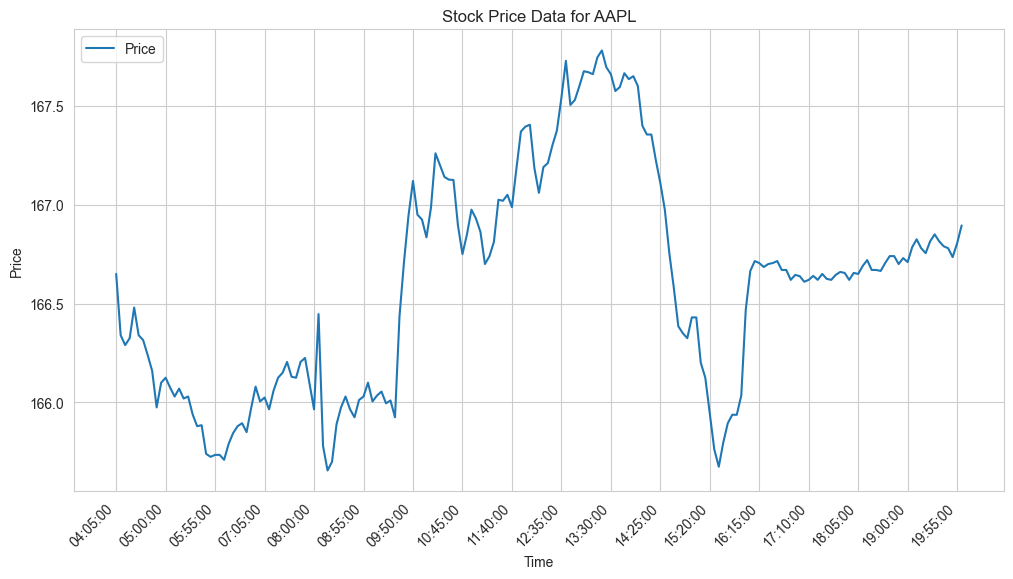

In [106]:
import seaborn as sns

df = df.sort_values(by='datetime', ascending=True)
df = df.loc[df['date'] == pd.to_datetime('2023-04-20')]
plot_data = ['average']
cols = ['Price', 'Rolling 10d Avg.', 'Rolling 30d Avg.']
df['datetime'] = pd.to_datetime(df['datetime'])
fig, ax = plt.subplots(figsize=(12,6))
for i, col in enumerate(plot_data):
    ax.plot(df[col], label=cols[i])

# Plot Bollinger Bands volatility trade signals
m = 2.5
# df.loc[(df['average'] >= df['rolling_10d_average'] + m*df['rolling_10d_std']), 'upper_10d'] = 1
# df.loc[(df['average'] <= df['rolling_10d_average'] - m*df['rolling_10d_std']), 'lower_10d'] = 1
# df.loc[(df['average'] >= df['rolling_30d_average'] + m*df['rolling_30d_std']), 'upper_30d'] = 1
# df.loc[(df['average'] <= df['rolling_30d_average'] - m*df['rolling_30d_std']), 'lower_30d'] = 1
# ax.scatter(df.loc[df['lower_10d']==1].index, df.loc[df['lower_10d']==1, 'average'], marker='x', s=75, color='red', label='Bollinger 10-day (buy)', zorder=1)
# ax.scatter(df.loc[df['upper_10d']==1].index, df.loc[df['upper_10d']==1, 'average'], marker='x', s=75, color='blue', label='Bollinger 10-day (sell)', zorder=1)
# ax.scatter(df.loc[df['lower_30d']==1].index, df.loc[df['lower_30d']==1, 'average'], marker='x', s=75, color='red', label='Bollinger 30-day (buy)', zorder=1)
# ax.scatter(df.loc[df['upper_30d']==1].index, df.loc[df['upper_30d']==1, 'average'], marker='x', s=75, color='blue', label='Bollinger 30-day (sell)', zorder=1)

# Plot geometric volatility trade signals
# df.loc[(df['wp_distance_10d'] >= epsilon) & (df['average'] > df['rolling_10d_average']), 'geo_upper_10d'] = 1
# df.loc[(df['wp_distance_10d'] >= epsilon) & (df['average'] <= df['rolling_10d_average']), 'geo_lower_10d'] = 1
# df.loc[(df['wp_distance_30d'] >= epsilon) & (df['average'] > df['rolling_30d_average']), 'geo_upper_30d'] = 1
# df.loc[(df['wp_distance_30d'] >= epsilon) & (df['average'] <= df['rolling_30d_average']), 'geo_lower_30d'] = 1
# ax.scatter(df.loc[df['geo_lower_10d']==1].index, df.loc[df['geo_lower_10d']==1, 'average'], marker='x', s=75, color='green', label='Geometric Vol. 10-day (buy)', zorder=3)
# ax.scatter(df.loc[df['geo_upper_10d']==1].index, df.loc[df['geo_upper_10d']==1, 'average'], marker='x', s=75, color='orange', label='Geometric Vol. 10-day (sell)', zorder=3)
# ax.scatter(df.loc[df['geo_lower_30d']==1].index, df.loc[df['geo_lower_30d']==1, 'average'], marker='x', s=75, color='green', label='Geometric Vol. 30-day (buy)', zorder=2)
# ax.scatter(df.loc[df['geo_upper_30d']==1].index, df.loc[df['geo_upper_30d']==1, 'average'], marker='x', s=75, color='orange', label='Geometric Vol. 30-day (sell)', zorder=2)

print(df.index)
tick_locations = range(3486, 3674, 11) 
ax.set_xticks(tick_locations)
ax.set_xticklabels(df['time'][tick_locations], rotation=45, ha='right')
ax.grid(True)

plt.title(f"Stock Price Data for AAPL")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.show()

['04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00']


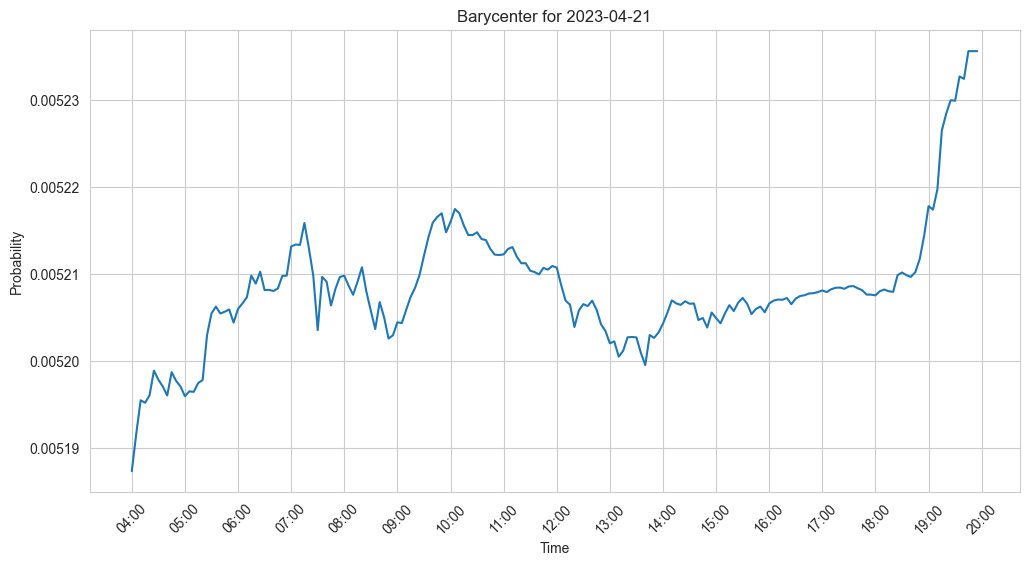

In [87]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

tickers = [f"{h:02}:00" for h in range(4, 21)]
print(tickers)
ax.set_xticks(range(0, len(tickers)*12, 12))
ax.set_xticklabels(tickers, rotation=45)

ax.grid(True)
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Barycenter for 2023-04-21')
plt.plot(barycenters_10d['2023-04-21'])

In [130]:
df.tail(20)

time      open      high       low     close  volume  \
3828  17:55:00  164.9715  164.9715  164.9700  164.9700    1886   
3829  18:00:00  164.9500  164.9500  164.9500  164.9500     195   
3830  18:05:00  164.9501  164.9501  164.9501  164.9501     223   
3831  18:10:00  164.9800  165.0000  164.9800  165.0000     595   
3832  18:15:00  164.9601  164.9601  164.9500  164.9500    1783   
3833  18:20:00  164.9600  164.9600  164.9600  164.9600     837   
3834  18:25:00  164.9600  164.9600  164.9500  164.9500     855   
3835  18:30:00  164.9600  164.9600  164.9500  164.9500    1592   
3836  18:35:00  164.9500  164.9500  164.9500  164.9500    3012   
3837  18:45:00  164.9600  164.9800  164.9600  164.9800     732   
3838  18:50:00  164.9600  164.9600  164.9100  164.9100    5445   
3839  18:55:00  164.9100  164.9100  164.9100  164.9100     214   
3840  19:05:00  164.9000  164.9100  164.9000  164.9100     934   
3841  19:10:00  164.9600  164.9600  164.9600  164.9600     216   
3842  19:30:00  164.9400  164.9400  164.9400  164.9400     246   
3843  19:35:00  164.9400  164.9400  164.9100  164.9200    2989   
3844  19:40:00  164.9000  164.9000  164.9000  164.9000     603   
3845  19:50:00  164.9200  164.9400  164.9200  164.9400    1592   
3846  19:55:00  164.9400  165.0000  164.9400  165.0000    1965   
3847  20:00:00  164.9700  164.9700  164.9200  164.9201    1494   

                datetime       date    average  rolling_10d_average  \
3828 2023-04-21 17:55:00 2023-04-21  164.97075           164.231194   
3829 2023-04-21 18:00:00 2023-04-21  164.95000           164.232478   
3830 2023-04-21 18:05:00 2023-04-21  164.95010           164.233603   
3831 2023-04-21 18:10:00 2023-04-21  164.99000           164.234602   
3832 2023-04-21 18:15:00 2023-04-21  164.95505           164.235576   
3833 2023-04-21 18:20:00 2023-04-21  164.96000           164.236542   
3834 2023-04-21 18:25:00 2023-04-21  164.95500           164.237555   
3835 2023-04-21 18:30:00 2023-04-21  164.95500           164.238484   
3836 2023-04-21 18:35:00 2023-04-21  164.95000           164.239326   
3837 2023-04-21 18:45:00 2023-04-21  164.97000           164.240122   
3838 2023-04-21 18:50:00 2023-04-21  164.93500           164.240932   
3839 2023-04-21 18:55:00 2023-04-21  164.91000           164.241729   
3840 2023-04-21 19:05:00 2023-04-21  164.90500           164.242563   
3841 2023-04-21 19:10:00 2023-04-21  164.96000           164.243461   
3842 2023-04-21 19:30:00 2023-04-21  164.94000           164.244211   
3843 2023-04-21 19:35:00 2023-04-21  164.92500           164.244781   
3844 2023-04-21 19:40:00 2023-04-21  164.90000           164.245300   
3845 2023-04-21 19:50:00 2023-04-21  164.93000           164.245790   
3846 2023-04-21 19:55:00 2023-04-21  164.97000           164.246222   
3847 2023-04-21 20:00:00 2023-04-21  164.94500           164.246587   

      rolling_30d_average wp_distance_10d alpha_10d  alpha_10d_2  \
3828                  NaN        0.004415         0            0   
3829                  NaN        0.001474         0            0   
3830                  NaN        0.002896         0            0   
3831                  NaN        0.004624         0            0   
3832                  NaN        0.006224         0            0   
3833                  NaN        0.009577         0            0   
3834                  NaN        0.010418         0            0   
3835                  NaN            None      None            0   
3836                  NaN            None      None            0   
3837                  NaN            None      None            0   
3838                  NaN            None      None            0   
3839                  NaN            None      None            0   
3840                  NaN            None      None            0   
3841                  NaN            None      None            0   
3842                  NaN            None      None            0   
3843                  NaN            None  